# Installations

In [1]:
!pip install -U torch
!pip install -U torch_geometric
!pip install -U numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 12.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=5ea771dee8fd03ab279753cafe85d69ec93d67c160ccd5cb3110078f89123afd
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 33.8 MB/s eta 0:00:00
  Attempting uni

# Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
import torch
print(torch.__version__)
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import torch.nn as nn
import networkx as nx
from torch_geometric.utils.convert import from_networkx
from numba import njit, prange
import time
import seaborn as sns
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch_geometric.nn import GCNConv, GATConv, TransformerConv, NNConv, SGConv, ARMAConv, TAGConv, ChebConv, DNAConv, EdgeConv, FiLMConv, FastRGCNConv

2.0.1+cu118


# Loading data

In [3]:
df = pd.read_csv('./CR_graph_rel.csv') # or it can be NC_graph_rel.csv
df

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,node_0,node_5,мордвины,мордвины,29.81720,4
1,node_0,node_10,мордвины,мордвины,11.63220,1
2,node_0,node_11,мордвины,мордвины,23.90440,2
3,node_0,node_18,мордвины,мордвины,11.25290,1
4,node_0,node_20,мордвины,мордвины,8.88252,1
...,...,...,...,...,...,...
67498,node_3741,node_3752,белорусы,белорусы,9.51327,1
67499,node_3745,node_3755,белорусы,белорусы,9.23221,1
67500,node_3749,node_3764,белорусы,белорусы,10.63310,1
67501,node_3754,node_3755,украинцы,белорусы,8.04722,1


# Functions for preprocessing dataframe

In [4]:
@njit(cache=True)
def select_lines(train_nodes, test_nodes, df_processed):
    '''
    For each test node selects the row (edge) in almost (classes and nodes are int) raw dataframe (.csv file) that connects current test node with training nodes

    Parameters:
    train_nodes (np.array): (see as get_train_test_nodes() function)
    test_nodes (np.array): (see as get_train_test_nodes() function)
    df_processed (pandas dataframe): it is the same data from .csv but names of nodes and nationalities are int now (containa all information)

    Returns:
    rows_for_adding_per_node (list of lists): num rows (edges) from df_processed to latly add
    '''
    
    rows_for_adding_per_node = []
    
    for i in range(len(test_nodes)):
        tmp = []
        for j in range(df_processed.shape[0]):
            row = df_processed[j]
            if int(row[0]) == test_nodes[i] and int(row[1]) in train_nodes or int(row[1]) == test_nodes[i] and int(row[0]) in train_nodes:
                
                tmp.append(j)
                
        rows_for_adding_per_node.append(tmp)
    
    return rows_for_adding_per_node


@njit(cache=True)
def calculate_sum_of_idb_for_each_node(sum_task_ibd, df_for_task, hashmap, mask_array):
    '''
    Compute features (namely sum of ibd scores per each class) for each node

    Parameters:
    sum_task_ibd (np.array): matrix with the shape of (num_train_or_test_nodes, num_classes) that contains node features
    df_for_task (np.array): numpy array from pandas dataframe for training or testing
    hashmap (np.array): hashmap of train or train + 1 test node
    mask_array (np.array): (see as get_train_test_nodes() function)

    Returns:
    Nothing. Everything is modified in place
    '''
    
    for i in range(df_for_task.shape[0]):
        row = df_for_task[i]
        if mask_array[hashmap[int(row[0])]]:
            sum_task_ibd[hashmap[int(row[0])], int(row[3])] += row[4]
            sum_task_ibd[hashmap[int(row[1])], int(row[2])] += row[4]


@njit(cache=True)
def construct_edges(df_for_task, hashmap):
    '''
    Aggregates edges and edge weights in suitable for pytorch geometric format

    Parameters:
    df_for_task (np.array): (see as calculate_sum_of_idb_for_each_node() function)
    hashmap (np.array): (see as calculate_sum_of_idb_for_each_node() function)

    Returns:
    graph_weighted_edges (np.array): array of edges and its weights
    '''
    
    graph_weighted_edges = []
    
    for i in range(df_for_task.shape[0]):
        row = df_for_task[i]
        graph_weighted_edges.append([hashmap[int(row[0])], hashmap[int(row[1])], row[4]])
        graph_weighted_edges.append([hashmap[int(row[1])], hashmap[int(row[0])], row[4]])
        
    return np.array(graph_weighted_edges)


@njit(cache=True)
def drop_rows_for_training_dataset(df_processed, test_nodes):
    '''
    Drops rows in preprocessed graph (where classes and nodes are int) that contain test nodes

    Parameters:
    df_processed (np.array): (see as select_lines() function)
    test_nodes (np.array): (see as get_train_test_nodes() function)

    Returns:
    drop_rows (list): ids of rows (edges) that should be dropped
    '''

    drop_rows = []
    for i in range(df_processed.shape[0]): # speed it up in future
        if i % 1000 == 0:
            print(f'Processed {i} / {df_processed.shape[0]} lines for training dataset')
        row = df_processed[i, :]
        if int(row[0]) in test_nodes or int(row[1]) in test_nodes:
            drop_rows.append(i)
            
    return drop_rows


@njit(cache=True)
def construct_node_classes(node_classes_sorted, current_nodes):
    '''
    Gets classes of given nodes

    Parameters:
    node_classes_sorted (np.array): (see as make_train_test_dataset() function)
    current_nodes (np.array): array of node ids

    Returns:
    targets (list): int classes of given nodes
    '''

    targets = []
    for node in current_nodes:
        targets.append(node_classes_sorted[node, 1])
        
    return targets

In [5]:
def get_train_test_nodes(df, train_coeff, mask_coeff, NC=False):
    '''
    Just splits nodes into two classes: nodes for train dataset and nodes for testing datasetS (we have multiple testing datasets)
    
    Parameters:
    df (pandas dataframe): just raw dataframe from .csv file
    train_coeff (int): proportion of nodes that goes to train dataset (same per each class)
    mask_coeff (int): proportion of nodes that will be masked in train dataset (same per each class)
    NC (bool): dataset type (CR or NC)

    Returns:
    train_nodes (list): contains isd of nodes in training dataset
    test_nodes (list): contains ids of nodes that is meant to be in testing datasets
    node_classes_sorted (pandas dataframe): dataframe with shape of (N, 2) that contains int class for each node (nodes are sorted by its id)
    mask_array (list): array that contains bool values for nodes in train dataset to mask them when computing loss
    '''
    
    # get list of all labels
    types = pd.concat([df['label_id1'], df['label_id2']], axis=0).unique().tolist()
    # print("TYPES: ", types)
    
    # concatenate all nodes in one column
    n = pd.concat([df['node_id1'], df['node_id2']], axis=0)
    
    # concatenate all labels in one column
    l = pd.concat([df['label_id1'], df['label_id2']], axis=0)
    
    # merge all nodes and all labels column-wise
    df_new = pd.concat([n, l], axis=1)
    
    # get class for every node and rename it using int numbers
    df_new.iloc[:, 0] = df_new.iloc[:, 0].apply(lambda n: int(n.split('_')[1]))
    df_new.iloc[:, 1] = df_new.iloc[:, 1].apply(lambda t: types.index(t))
    df_new = df_new.drop_duplicates()
    node_classes_random = df_new.sample(frac=1)
    node_classes_sorted = df_new.sort_values(by=[0])
    
    if NC:
        missed_nodes = []
        for i in range(node_classes_sorted.shape[0]):
            if i not in node_classes_sorted.iloc[:, 0].to_numpy():
                missed_nodes.append([i, -1])
        
        tmp_df = pd.DataFrame(missed_nodes)
        
        print('TMP_DF: ', tmp_df)
        
        node_classes_sorted = pd.concat([node_classes_sorted, tmp_df], axis=0).sort_values(by=[0])
    
    # get number of nodes for every class
    num_nodes_per_class = node_classes_random.iloc[:, 1].value_counts()
    
    train_nodes, test_nodes = [], []
    node_counter = {i:0 for i in range(num_nodes_per_class.shape[0])}
    
    # add masking
    mask_array = []
    
    # split nodes
    for i in range(node_classes_random.shape[0]):
        node_class = node_classes_random.iloc[i, 1]
        if node_counter[node_class] < int(train_coeff * num_nodes_per_class.loc[node_class]):
            train_nodes.append(node_classes_random.iloc[i, 0])
            
            if node_counter[node_class] >= int(mask_coeff * train_coeff * num_nodes_per_class.loc[node_class]):
                mask_array.append(True)
            else:
                mask_array.append(False)
            
            node_counter[node_class] += 1
        else:
            test_nodes.append(node_classes_random.iloc[i, 0])
    
    return train_nodes, test_nodes, node_classes_sorted, mask_array

def make_train_test_dataset(df, train_nodes, test_nodes, node_classes_sorted, mask_array):
    '''
    Makes train and testing datasets

    Parameters:
    df (pandas dataframe): just raw dataframe from .csv file
    train_nodes (list): (see as get_train_test_nodes() function)
    test_nodes (list): (see as get_train_test_nodes() function)
    node_classes_sorted (pandas dataframe): (nodes are sorted by its id) (see as get_train_test_nodes() function)
    mask_array (list): (see as get_train_test_nodes() function)

    Returns:
    train_graph_pytorch (pytorch geometric Data object): train dataset that is suitable for pytorch geometric GNN
    array_of_graphs_for_testing (array of pytorch geometric Data objects): array of test datasets that are suitable for pytorch geometric GNN
    types (list): just list of unique nationalities in current dataset
    '''
    
    train_mask_array = mask_array
    
    # get list of all labels
    types = pd.concat([df['label_id1'], df['label_id2']], axis=0).unique().tolist()
    # print("TYPES: ", types)
    
    # preprocess initial data
    df_processed = df.copy()
    df_processed.iloc[:, 0] = df_processed.iloc[:, 0].apply(lambda n: int(n.split('_')[1]))
    df_processed.iloc[:, 1] = df_processed.iloc[:, 1].apply(lambda n: int(n.split('_')[1]))
    df_processed.iloc[:, 2] = df_processed.iloc[:, 2].apply(lambda t: types.index(t))
    df_processed.iloc[:, 3] = df_processed.iloc[:, 3].apply(lambda t: types.index(t))
    
    # making dataframe with only training nodes
    df_for_training = df_processed.copy()
    
    drop_rows = drop_rows_for_training_dataset(df_for_training.to_numpy(), np.array(test_nodes))
    
    df_for_training = df_for_training.drop(drop_rows)
    
    # construct training graph ############################# SAME PART BELOW ##############################
    
    # construct hashmap for training nodes
    hashmap = np.array([1e6 for i in range(len(node_classes_sorted))]).astype(int)
    for i, node in enumerate(train_nodes):
        hashmap[node] = i
        
    # print(hashmap)
    
    # calculate sum of idb for each training node
    sum_training_idb = np.zeros((len(train_nodes), len(types)))
    
    calculate_sum_of_idb_for_each_node(sum_training_idb, df_for_training.to_numpy(), hashmap, np.array(train_mask_array))
        
    # print(node_classes_sorted)
                
    # construct targets
    targets = construct_node_classes(node_classes_sorted.to_numpy(), train_nodes)
        
    # construct edges
    train_graph_weighted_edges = construct_edges(df_for_training.to_numpy(), hashmap)
    
    sort_idx = np.lexsort((train_graph_weighted_edges[:, 1], train_graph_weighted_edges[:, 0]))
    train_graph_weighted_edges = train_graph_weighted_edges[sort_idx]
    
    train_graph_pytorch = Data.from_dict({'y': torch.tensor(targets, dtype=torch.long), 'x': torch.tensor(sum_training_idb), 'weight': torch.tensor(train_graph_weighted_edges[:, 2]), 'edge_index': torch.tensor(train_graph_weighted_edges[:, :2].T, dtype=torch.long)})
    
    train_graph_pytorch.num_classes = len(types)

    if len(np.unique(train_graph_pytorch.edge_index.cpu().detach().numpy())) != len(train_nodes):
        raise Exception("Train graph is not connected!!! Restart assembling!")
    
    ############################# SAME PART UP ##############################
    
    # creating array of graphs for testing
    
    array_of_graphs_for_testing = []
    
    # print('Starting selecting lines...')
    
    start = time.time()
    
    rows_for_adding_per_node = select_lines(np.array(train_nodes), np.array(test_nodes), df_processed.to_numpy())
    
    end = time.time()
    
    # print(f'Done selecting lines in {end-start} seconds')
    
    warning_counter = 0
    
    for k, test_node in enumerate(test_nodes):
        
        print(f'Processed {k} / {len(test_nodes)} nodes')
        
        test_mask_array = train_mask_array + [True]
        
        rows_for_adding = rows_for_adding_per_node[k]
                
        df_for_testing = pd.concat([df_for_training, df_processed.iloc[rows_for_adding]], axis=0)
        
        # print(df_for_testing.shape, df_for_training.shape)
        
        if df_for_testing.shape[0] == df_for_training.shape[0]:
            warning_counter += 1
        
        current_test_nodes = train_nodes + [test_node]
        
        # construct testing graph ############################# SAME PART BELOW ##############################
    
        start = time.time()
        
        # construct hash map for training nodes
        hashmap = np.array([1e6 for i in range(len(node_classes_sorted))]).astype(int) # why 1e6? It can be whatever number, it's just a int placeholder
        for i, node in enumerate(current_test_nodes):
            hashmap[node] = i 
    
        # calculate sum of idb for each training node
        sum_testing_idb = np.zeros((len(current_test_nodes), len(types)))
    
        calculate_sum_of_idb_for_each_node(sum_testing_idb, df_for_testing.to_numpy(), hashmap, np.array(test_mask_array))
            
        # print(f'calculate sum of idb for each training node: {time.time() - start}')
        
        start = time.time()

        # construct targets
        targets = construct_node_classes(node_classes_sorted.to_numpy(), current_test_nodes)
            
        # print(f'construct targets: {time.time() - start}')
        
        start = time.time()

        # construct edges
        test_graph_weighted_edges = construct_edges(df_for_testing.to_numpy(), hashmap)
        
        sort_idx = np.lexsort((test_graph_weighted_edges[:, 1], test_graph_weighted_edges[:, 0]))
        test_graph_weighted_edges = test_graph_weighted_edges[sort_idx]
            
        # print(f'construct edges: {time.time() - start}')

        test_graph_pytorch = Data.from_dict({'y': torch.tensor(targets, dtype=torch.long), 'x': torch.tensor(sum_testing_idb), 'weight': torch.tensor(test_graph_weighted_edges[:, 2]), 'edge_index': torch.tensor(test_graph_weighted_edges[:, :2].T, dtype=torch.long)})
        
        test_graph_pytorch.num_classes = len(types)
        
        array_of_graphs_for_testing.append(test_graph_pytorch)
        
        ############################# SAME PART UP ##############################
        
    print('WARNING COUNTER:', warning_counter) # it checks that each test node has at least one connection to train nodes (otherwise it will be non zero which often happens in NC dataset)
    
    return train_graph_pytorch, array_of_graphs_for_testing, types

# Making all needed datasets

In [6]:
tr, ts, nks, mask_array = get_train_test_nodes(df, 0.7, mask_coeff=0.0, NC=False) # 70:30 split ratio (70% nodes for training, 30% for testing)
data, test_graphs, types = make_train_test_dataset(df, tr, ts, nks, mask_array)

<ipython-input-5-b3146f6c942b>:32: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_new.iloc[:, 0] = df_new.iloc[:, 0].apply(lambda n: int(n.split('_')[1]))
<ipython-input-5-b3146f6c942b>:33: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_new.iloc[:, 1] = df_new.iloc[:, 1].apply(lambda t: types.index(t))
<ipython-input-5-b3146f6c942b>:101: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]]

Processed 0 / 67503 lines for training dataset
Processed 1000 / 67503 lines for training dataset
Processed 2000 / 67503 lines for training dataset
Processed 3000 / 67503 lines for training dataset
Processed 4000 / 67503 lines for training dataset
Processed 5000 / 67503 lines for training dataset
Processed 6000 / 67503 lines for training dataset
Processed 7000 / 67503 lines for training dataset
Processed 8000 / 67503 lines for training dataset
Processed 9000 / 67503 lines for training dataset
Processed 10000 / 67503 lines for training dataset
Processed 11000 / 67503 lines for training dataset
Processed 12000 / 67503 lines for training dataset
Processed 13000 / 67503 lines for training dataset
Processed 14000 / 67503 lines for training dataset
Processed 15000 / 67503 lines for training dataset
Processed 16000 / 67503 lines for training dataset
Processed 17000 / 67503 lines for training dataset
Processed 18000 / 67503 lines for training dataset
Processed 19000 / 67503 lines for training d

/usr/local/lib/python3.10/dist-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'current_nodes' of function 'construct_node_classes'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-e097a3886e1a>", line 100:
@njit(cache=True)
def construct_node_classes(node_classes_sorted, current_nodes):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Processed 0 / 1132 nodes
Processed 1 / 1132 nodes
Processed 2 / 1132 nodes
Processed 3 / 1132 nodes
Processed 4 / 1132 nodes
Processed 5 / 1132 nodes
Processed 6 / 1132 nodes
Processed 7 / 1132 nodes
Processed 8 / 1132 nodes
Processed 9 / 1132 nodes
Processed 10 / 1132 nodes
Processed 11 / 1132 nodes
Processed 12 / 1132 nodes
Processed 13 / 1132 nodes
Processed 14 / 1132 nodes
Processed 15 / 1132 nodes
Processed 16 / 1132 nodes
Processed 17 / 1132 nodes
Processed 18 / 1132 nodes
Processed 19 / 1132 nodes
Processed 20 / 1132 nodes
Processed 21 / 1132 nodes
Processed 22 / 1132 nodes
Processed 23 / 1132 nodes
Processed 24 / 1132 nodes
Processed 25 / 1132 nodes
Processed 26 / 1132 nodes
Processed 27 / 1132 nodes
Processed 28 / 1132 nodes
Processed 29 / 1132 nodes
Processed 30 / 1132 nodes
Processed 31 / 1132 nodes
Processed 32 / 1132 nodes
Processed 33 / 1132 nodes
Processed 34 / 1132 nodes
Processed 35 / 1132 nodes
Processed 36 / 1132 nodes
Processed 37 / 1132 nodes
Processed 38 / 1132 no

# Define GNN model

In [7]:
class TAGConv_3l_128h_w(torch.nn.Module):
    def __init__(self):
        super(TAGConv_3l_128h_w, self).__init__()
        self.conv1 = TAGConv(data.num_features, 128)
        self.conv2 = TAGConv(128, 128)
        self.conv3 = TAGConv(128, int(data.num_classes))

    def forward(self, data):

        x = data.x.float()
        edge_index = data.edge_index
        edge_attr = data.weight.float()

        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        
        return x

# Define functions for training

In [8]:
# types = ['Chechens', 'Kabardians, Circassians, Adyghes', 'Karachays, Balkars', 'Ingush', 'Dagestan peoples', 'Ossetians', 'Kumyks', 'Nogais']
types = ['Mordvins', 'Belarusians', 'Ukranians', 'Southern Russians', 'Northen Russians']

start = time.time()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TAGConv_3l_128h_w().to(device)

criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Define optimizer.

max_f1_score = 0
max_f1_score_macro = 0

def evaluation(model, test_graphs, step):
    
    global start
    
    print('Time elapsed in min: ', (time.time() - start) / 60)
    
    model.eval()
    y_true = []
    y_pred = []
    
    global max_f1_score, max_f1_score_macro

    for i in range(len(test_graphs)):
        p = F.softmax(model(test_graphs[i].to(device))[-1], dim=0).cpu().detach().numpy()
        y_pred.append(np.argmax(p))
        y_true.append(test_graphs[i].y[-1].cpu().detach())
    
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    y_true = np.array(y_true)
    
    plt.clf()
    fig, ax = plt.subplots(1, 1)
    sns.heatmap(cm, annot=True, fmt=".2f", ax=ax)
    ax.set_xticks([i for i in range(len(types))])
    ax.set_xticklabels([f'{t} ({len(y_true[y_true == n])})' for n, t in enumerate(types)])
    ax.set_yticks([i for i in range(len(types))])
    ax.set_yticklabels([f'{t} ({len(y_true[y_true == n])})' for n, t in enumerate(types)])
    fig.suptitle("Confusion matrix")
    plt.yticks(rotation=0)
    plt.xticks(rotation=90) 

    plt.show()
    
    current_f1_score = f1_score(y_true, y_pred, average='weighted')
    current_f1_score_macro = f1_score(y_true, y_pred, average='macro')
    
    print(f"Current f1 score weighted: {current_f1_score}")
    print(f"Current f1 score macro: {current_f1_score_macro}")
    if current_f1_score > max_f1_score:
        max_f1_score = current_f1_score
        
    if current_f1_score_macro > max_f1_score_macro:
        max_f1_score_macro = current_f1_score_macro
        
    print(f"Max f1 score weighted: {max_f1_score}")
    print(f"Max f1 score macro: {max_f1_score_macro}")
        
    model.train()
    

def train(data, log_step, num_epochs, test_graphs, mask_array):
    model.train()
    data =  data.to(device)
    for i in range(num_epochs):
        if i % log_step == 0:
            print(f'Step {i}')
            evaluation(model, test_graphs, i)
        optimizer.zero_grad()  # Clear gradients.
        out = model(data)  # Perform a single forward pass.
        loss = criterion(out[mask_array], data.y[mask_array])  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

# Train the model

Step 0
Time elapsed in min:  0.08438076178232828
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.00      0.00      0.00       139
           2       0.11      1.00      0.20       128
           3       0.00      0.00      0.00       654
           4       0.00      0.00      0.00       190

    accuracy                           0.11      1132
   macro avg       0.02      0.20      0.04      1132
weighted avg       0.01      0.11      0.02      1132



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

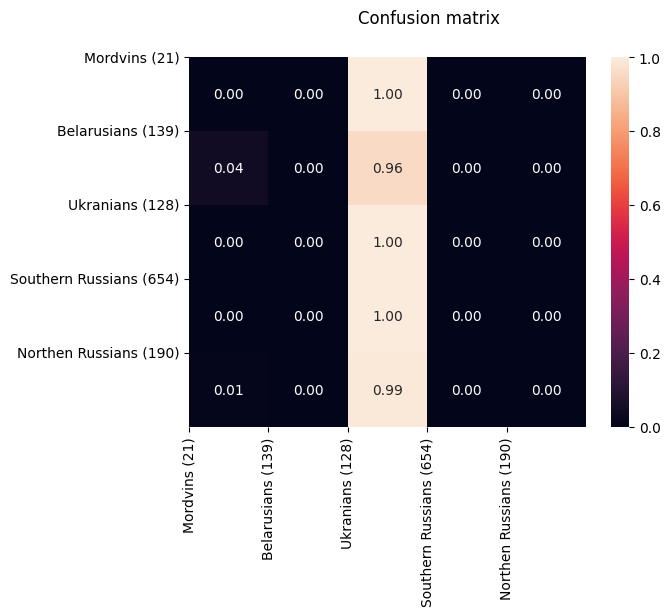

Current f1 score weighted: 0.02312060420641461
Current f1 score macro: 0.04089456869009584
Max f1 score weighted: 0.02312060420641461
Max f1 score macro: 0.04089456869009584
Step 1000
Time elapsed in min:  0.48578049341837565
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.94      0.91      0.92       139
           2       0.98      0.95      0.96       128
           3       0.98      0.98      0.98       654
           4       0.92      0.96      0.94       190

    accuracy                           0.96      1132
   macro avg       0.96      0.94      0.95      1132
weighted avg       0.96      0.96      0.96      1132



<Figure size 640x480 with 0 Axes>

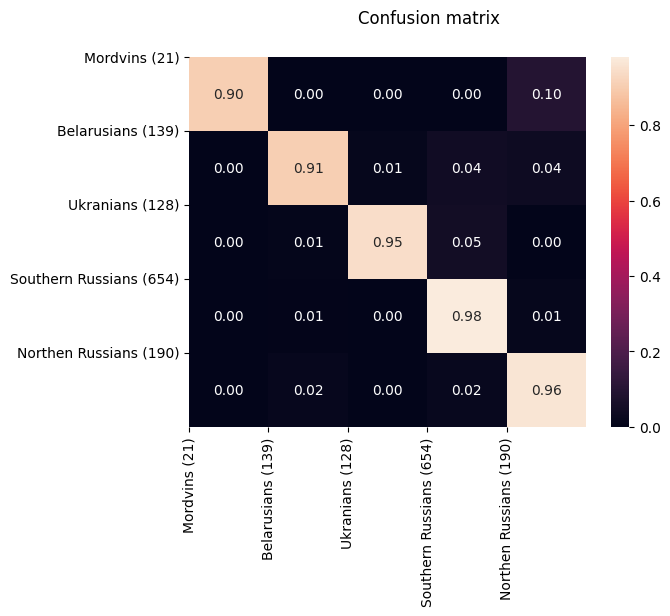

Current f1 score weighted: 0.9628430319170236
Current f1 score macro: 0.9509145667557048
Max f1 score weighted: 0.9628430319170236
Max f1 score macro: 0.9509145667557048
Step 2000
Time elapsed in min:  0.834405783812205
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.94      0.97      0.95       139
           2       0.98      0.95      0.97       128
           3       0.99      0.98      0.99       654
           4       0.95      0.97      0.96       190

    accuracy                           0.98      1132
   macro avg       0.97      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

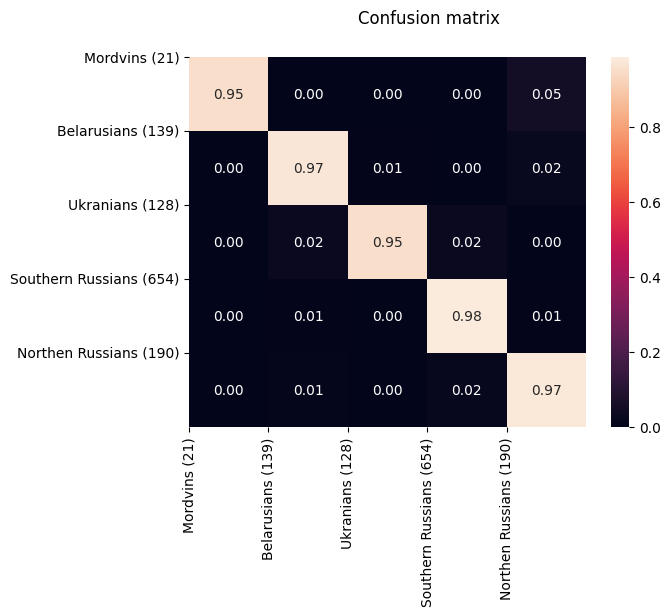

Current f1 score weighted: 0.9771091259658324
Current f1 score macro: 0.9698398113216344
Max f1 score weighted: 0.9771091259658324
Max f1 score macro: 0.9698398113216344
Step 3000
Time elapsed in min:  1.178206745783488
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.95      0.97      0.96       139
           2       0.98      0.96      0.97       128
           3       0.99      0.99      0.99       654
           4       0.96      0.97      0.97       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

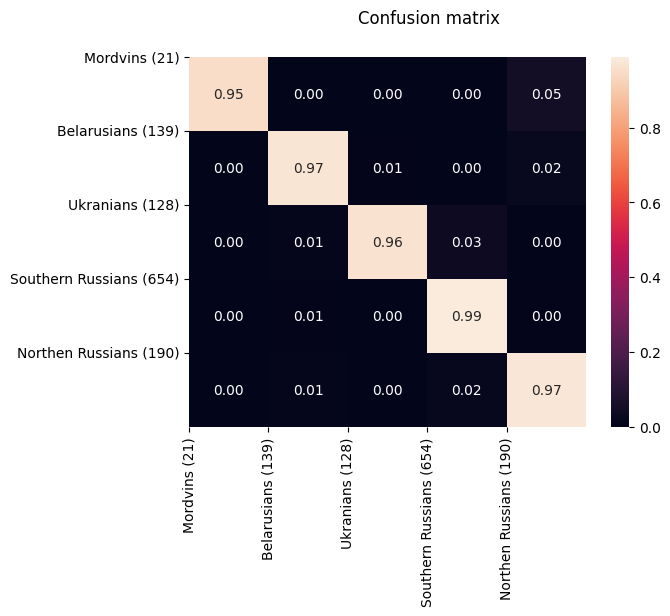

Current f1 score weighted: 0.9797090963281638
Current f1 score macro: 0.9731811175505571
Max f1 score weighted: 0.9797090963281638
Max f1 score macro: 0.9731811175505571
Step 4000
Time elapsed in min:  1.5187096039454142
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.96      0.97      0.97       139
           2       0.98      0.97      0.98       128
           3       0.99      0.99      0.99       654
           4       0.96      0.98      0.97       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.98      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

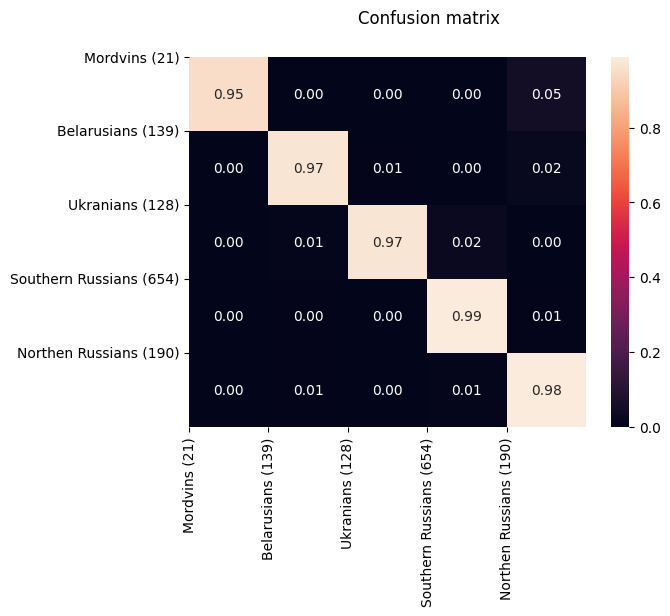

Current f1 score weighted: 0.9823646624609149
Current f1 score macro: 0.9762393059884309
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 5000
Time elapsed in min:  1.8600785295168558
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.96      0.96      0.96       139
           2       0.98      0.96      0.97       128
           3       0.99      0.99      0.99       654
           4       0.95      0.98      0.97       190

    accuracy                           0.98      1132
   macro avg       0.98      0.96      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

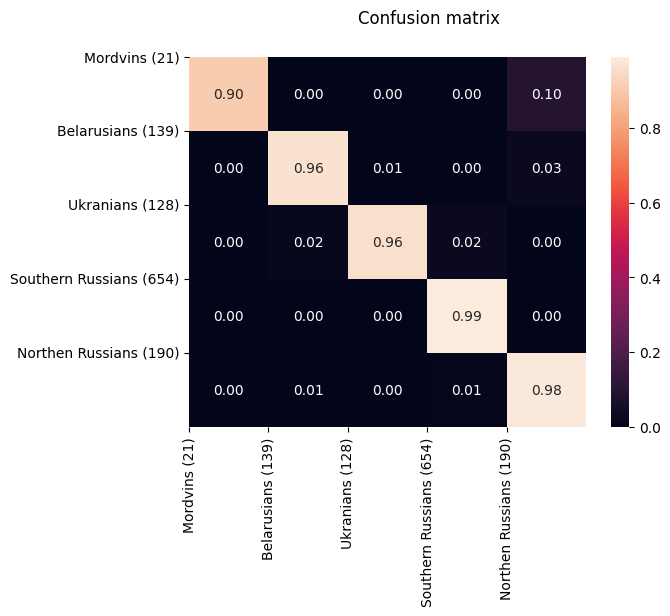

Current f1 score weighted: 0.9805762254175441
Current f1 score macro: 0.9685258096404699
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 6000
Time elapsed in min:  2.2018199880917866
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.96      0.96      0.96       139
           2       0.98      0.96      0.97       128
           3       0.99      0.99      0.99       654
           4       0.95      0.98      0.97       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

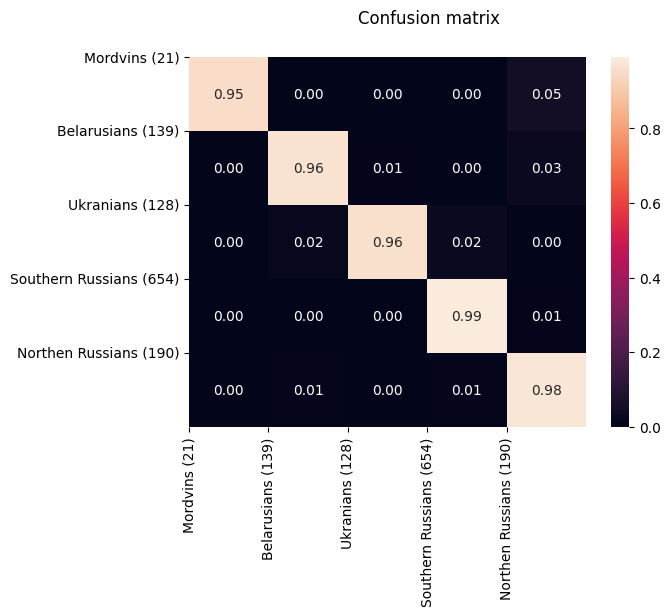

Current f1 score weighted: 0.9814721823109575
Current f1 score macro: 0.9739576189536141
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 7000
Time elapsed in min:  2.5466987331708273
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.95      0.96      0.96       139
           2       0.98      0.96      0.97       128
           3       0.99      0.99      0.99       654
           4       0.95      0.97      0.96       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

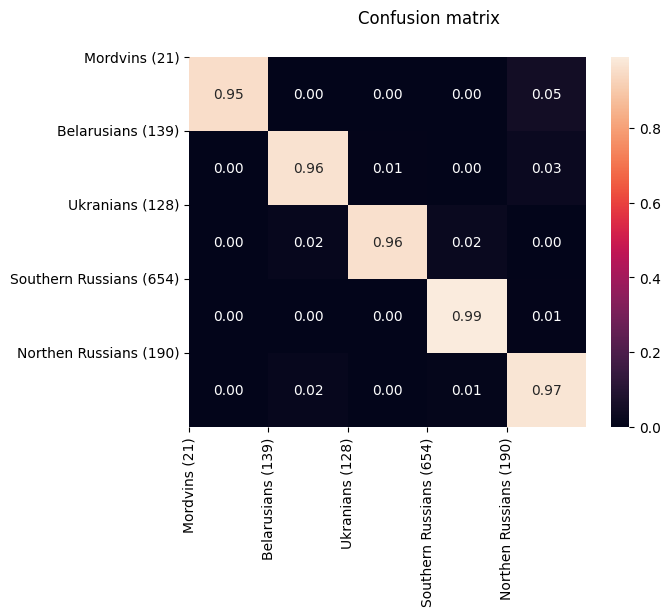

Current f1 score weighted: 0.9797286999557236
Current f1 score macro: 0.9718875868616959
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 8000
Time elapsed in min:  2.892895019054413
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.96      0.96      0.96       139
           2       0.98      0.96      0.97       128
           3       0.99      0.99      0.99       654
           4       0.95      0.97      0.96       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

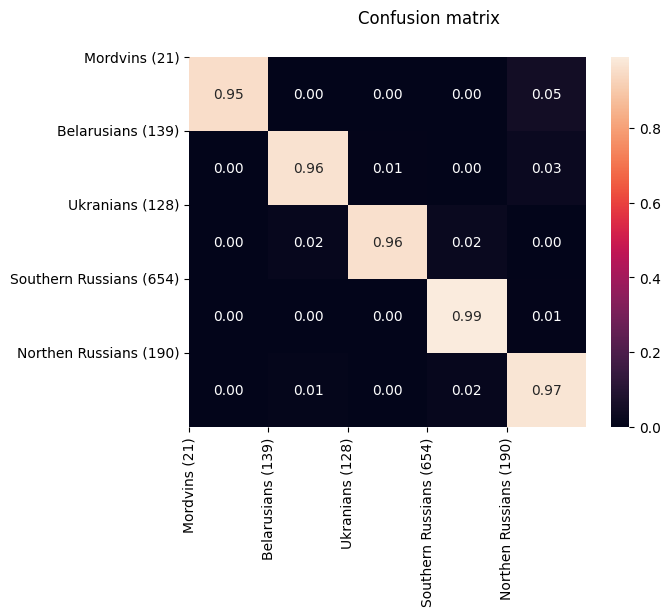

Current f1 score weighted: 0.9797119784531471
Current f1 score macro: 0.972422094608578
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 9000
Time elapsed in min:  3.240271464983622
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.96      0.96      0.96       139
           2       0.98      0.96      0.97       128
           3       0.99      0.99      0.99       654
           4       0.95      0.97      0.96       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

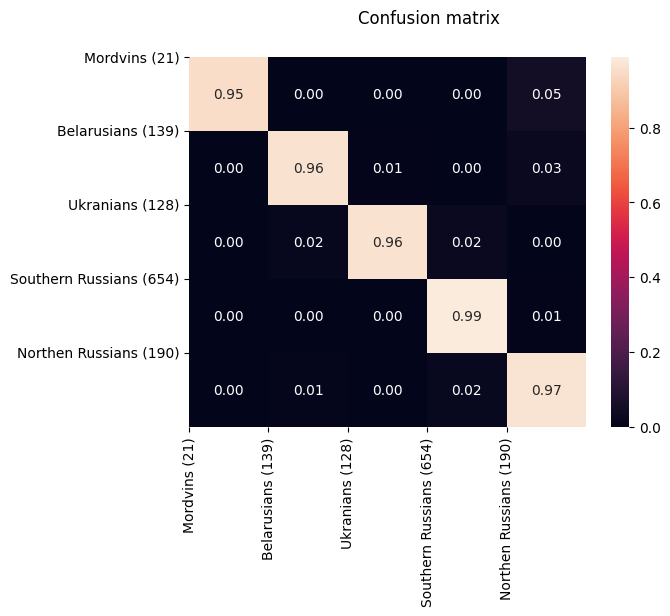

Current f1 score weighted: 0.9779537201101486
Current f1 score macro: 0.9710743835654766
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 10000
Time elapsed in min:  3.585120177268982
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.96      0.96      0.96       139
           2       0.98      0.96      0.97       128
           3       0.99      0.99      0.99       654
           4       0.95      0.97      0.96       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

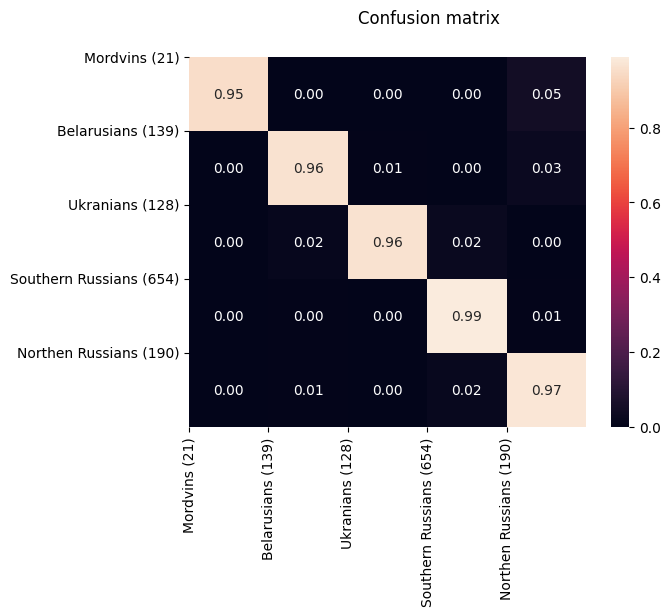

Current f1 score weighted: 0.9788279103339412
Current f1 score macro: 0.9721160502321433
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 11000
Time elapsed in min:  3.934499478340149
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.96      0.96      0.96       139
           2       0.98      0.97      0.98       128
           3       0.99      0.99      0.99       654
           4       0.95      0.97      0.96       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

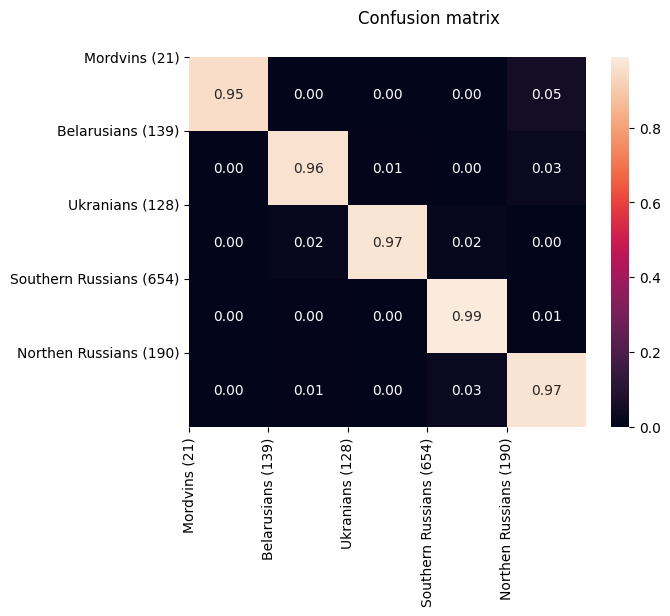

Current f1 score weighted: 0.9788311877179221
Current f1 score macro: 0.9723840061156122
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 12000
Time elapsed in min:  4.282634977499644
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.96      0.96      0.96       139
           2       0.98      0.97      0.98       128
           3       0.99      0.99      0.99       654
           4       0.95      0.97      0.96       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

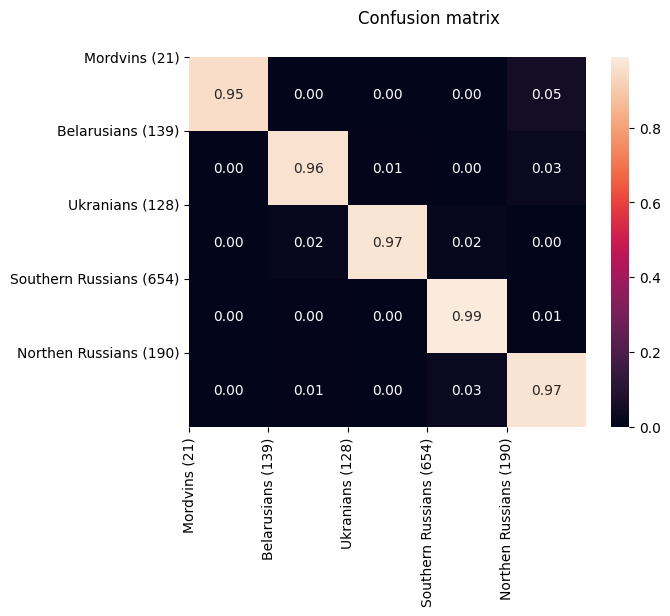

Current f1 score weighted: 0.9788311877179221
Current f1 score macro: 0.9723840061156122
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 13000
Time elapsed in min:  4.632921461264292
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.96      0.96      0.96       139
           2       0.98      0.97      0.98       128
           3       0.99      0.99      0.99       654
           4       0.95      0.97      0.96       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

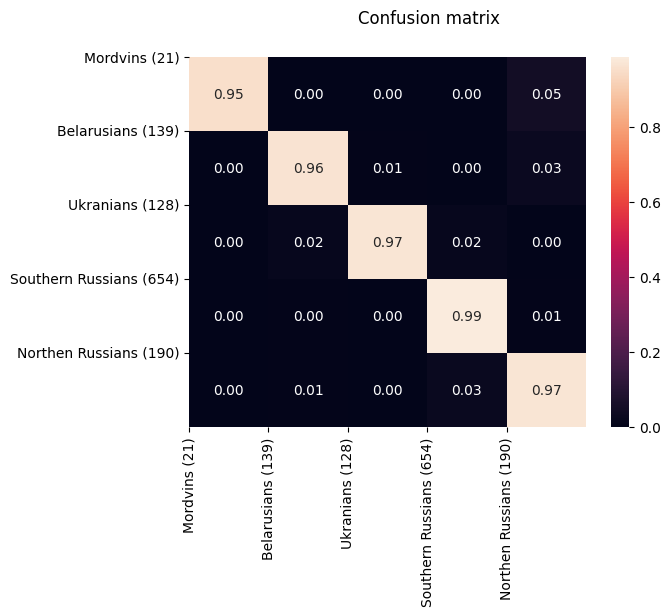

Current f1 score weighted: 0.9779637617290118
Current f1 score macro: 0.9717286740688266
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 14000
Time elapsed in min:  4.983467503388723
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.96      0.96      0.96       139
           2       0.98      0.97      0.98       128
           3       0.99      0.99      0.99       654
           4       0.95      0.97      0.96       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

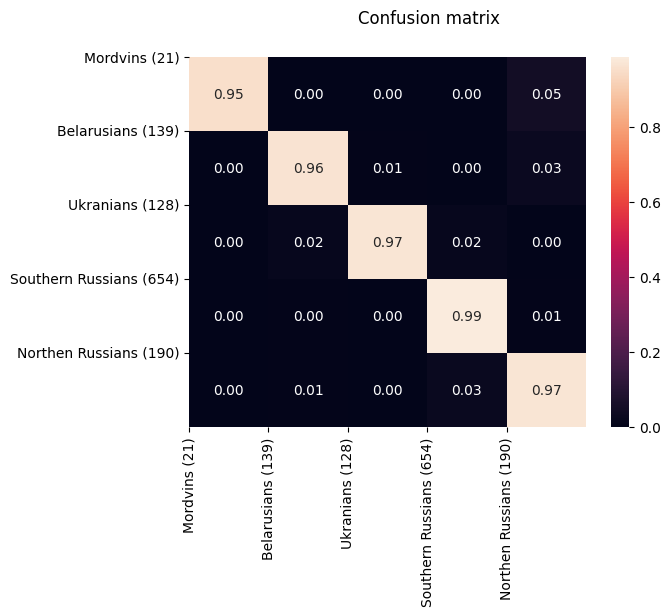

Current f1 score weighted: 0.9779637617290118
Current f1 score macro: 0.9717286740688266
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 15000
Time elapsed in min:  5.331165579954783
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.96      0.97      0.96       139
           2       0.98      0.97      0.98       128
           3       0.99      0.99      0.99       654
           4       0.95      0.97      0.96       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

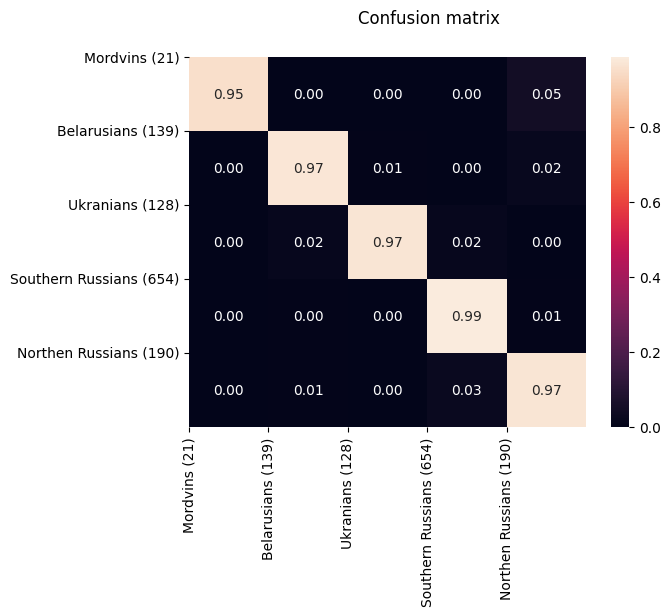

Current f1 score weighted: 0.978839569526737
Current f1 score macro: 0.9729715567464773
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 16000
Time elapsed in min:  5.680881623427073
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.96      0.97      0.96       139
           2       0.98      0.96      0.97       128
           3       0.99      0.99      0.99       654
           4       0.95      0.97      0.96       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

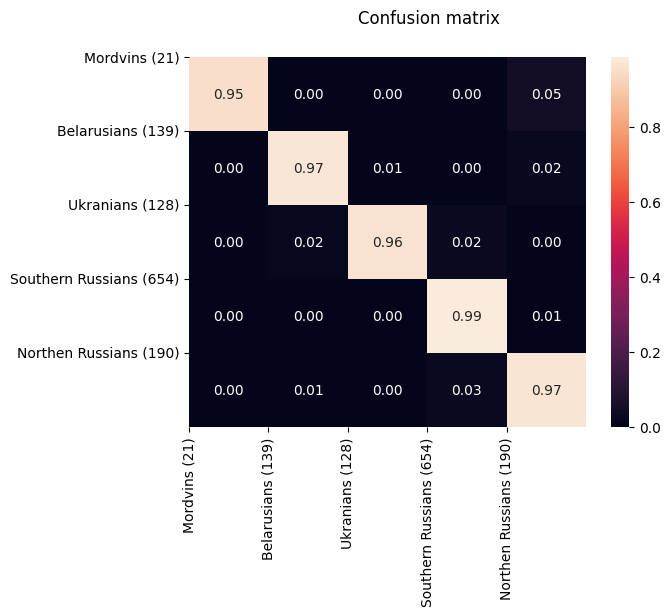

Current f1 score weighted: 0.9779454597886676
Current f1 score macro: 0.9720112218666926
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 17000
Time elapsed in min:  6.026259930928548
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.96      0.96      0.96       139
           2       0.98      0.96      0.97       128
           3       0.99      0.99      0.99       654
           4       0.95      0.97      0.96       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

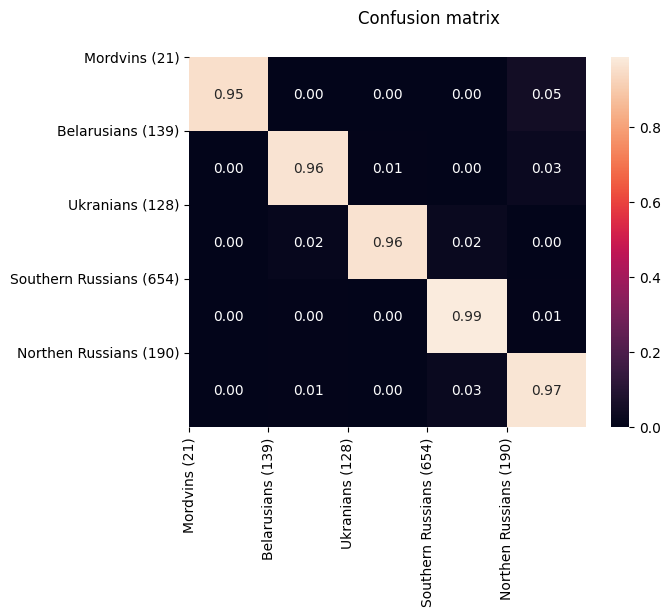

Current f1 score weighted: 0.9770696519909426
Current f1 score macro: 0.970768339189042
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 18000
Time elapsed in min:  6.376152090231577
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.96      0.96      0.96       139
           2       0.98      0.96      0.97       128
           3       0.99      0.99      0.99       654
           4       0.95      0.97      0.96       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

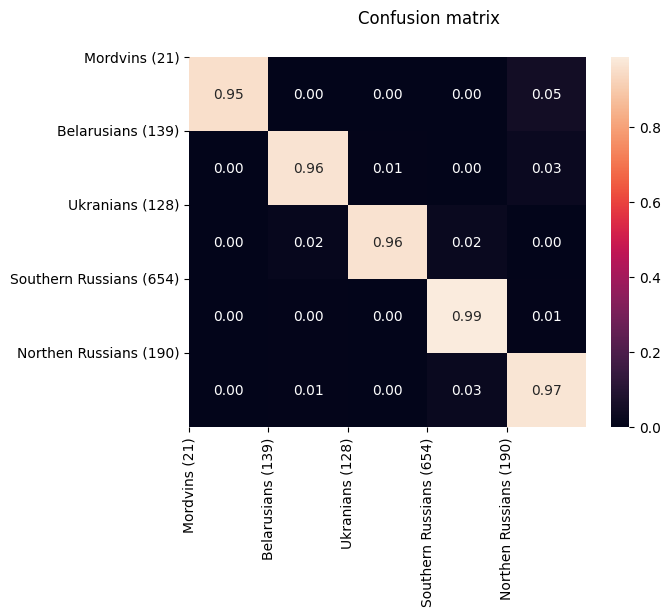

Current f1 score weighted: 0.9770696519909426
Current f1 score macro: 0.970768339189042
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 19000
Time elapsed in min:  6.724898235003153
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.96      0.96      0.96       139
           2       0.98      0.96      0.97       128
           3       0.99      0.99      0.99       654
           4       0.95      0.96      0.96       190

    accuracy                           0.98      1132
   macro avg       0.97      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

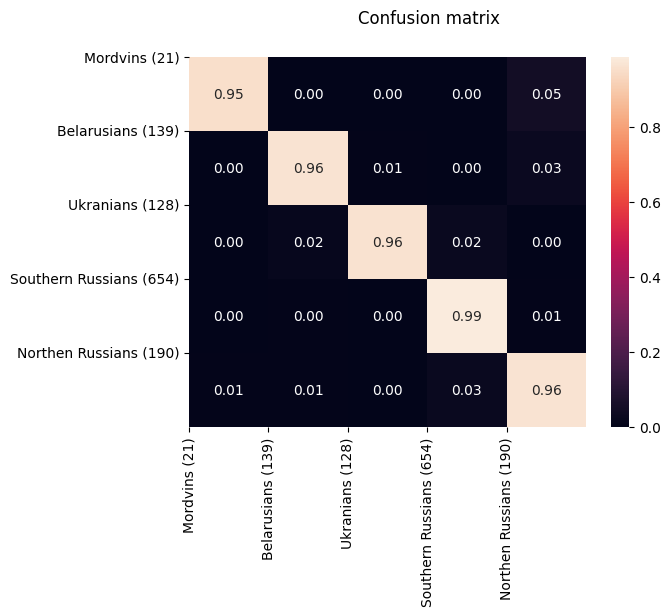

Current f1 score weighted: 0.9761822327533831
Current f1 score macro: 0.9655786271837533
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 20000
Time elapsed in min:  7.074865674972534
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.96      0.96      0.96       139
           2       0.98      0.96      0.97       128
           3       0.99      0.99      0.99       654
           4       0.95      0.96      0.96       190

    accuracy                           0.98      1132
   macro avg       0.97      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

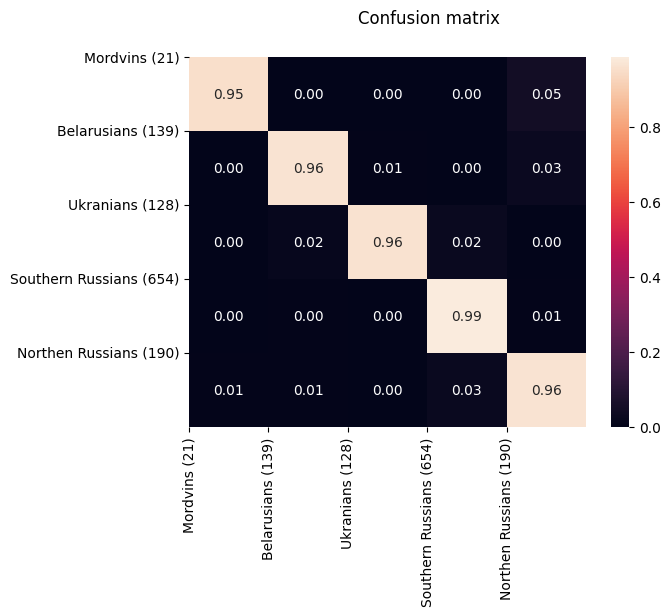

Current f1 score weighted: 0.9761822327533831
Current f1 score macro: 0.9655786271837533
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 21000
Time elapsed in min:  7.4298841993014015
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.96      0.96      0.96       139
           2       0.98      0.96      0.97       128
           3       0.99      0.99      0.99       654
           4       0.95      0.96      0.96       190

    accuracy                           0.98      1132
   macro avg       0.97      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

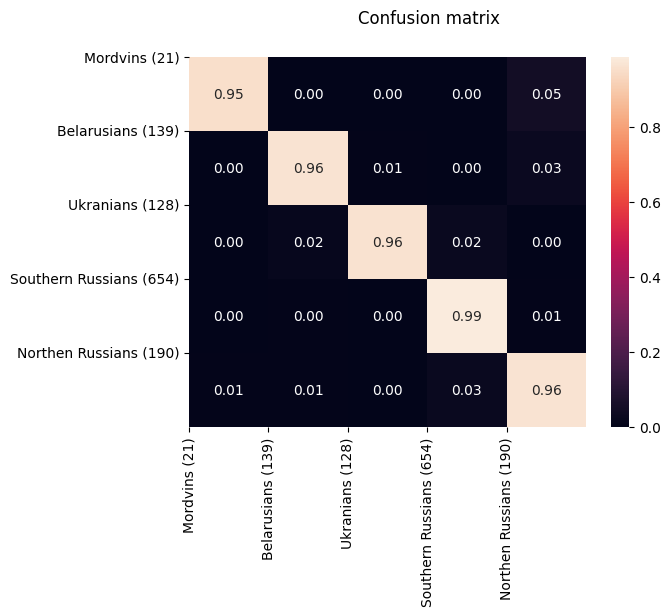

Current f1 score weighted: 0.9761822327533831
Current f1 score macro: 0.9655786271837533
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 22000
Time elapsed in min:  7.776519227027893
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.96      0.96      0.96       139
           2       0.98      0.96      0.97       128
           3       0.99      0.99      0.99       654
           4       0.94      0.96      0.95       190

    accuracy                           0.98      1132
   macro avg       0.96      0.96      0.96      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

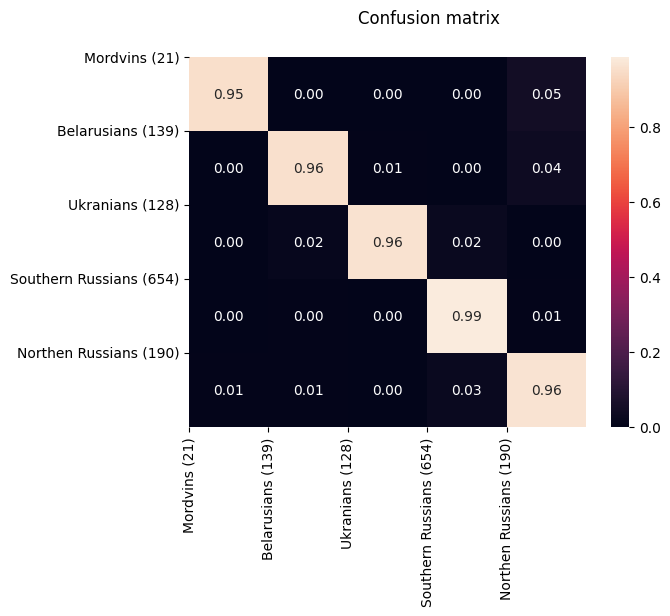

Current f1 score weighted: 0.9753054280748374
Current f1 score macro: 0.964333122913372
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 23000
Time elapsed in min:  8.126573503017426
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.96      0.96      0.96       139
           2       0.98      0.96      0.97       128
           3       0.99      0.99      0.99       654
           4       0.94      0.96      0.95       190

    accuracy                           0.98      1132
   macro avg       0.96      0.96      0.96      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

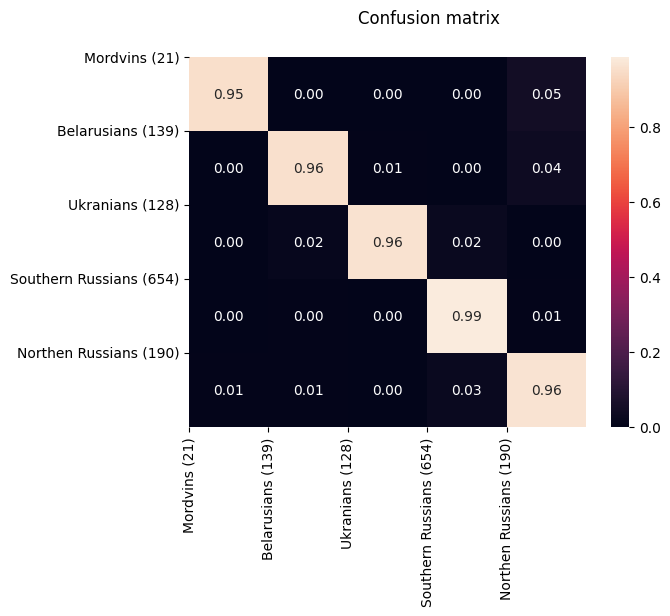

Current f1 score weighted: 0.9753054280748374
Current f1 score macro: 0.964333122913372
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 24000
Time elapsed in min:  8.47244987487793
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.96      0.96      0.96       139
           2       0.98      0.96      0.97       128
           3       0.99      0.99      0.99       654
           4       0.94      0.96      0.95       190

    accuracy                           0.97      1132
   macro avg       0.96      0.96      0.96      1132
weighted avg       0.97      0.97      0.97      1132



<Figure size 640x480 with 0 Axes>

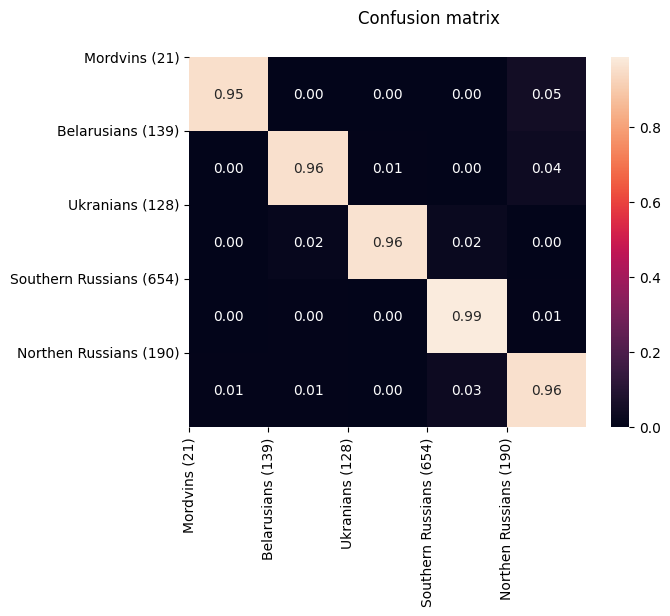

Current f1 score weighted: 0.974410698371336
Current f1 score macro: 0.9636355355168076
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 25000
Time elapsed in min:  8.822246098518372
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.96      0.96      0.96       139
           2       0.98      0.96      0.97       128
           3       0.99      0.99      0.99       654
           4       0.95      0.96      0.95       190

    accuracy                           0.98      1132
   macro avg       0.97      0.96      0.96      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

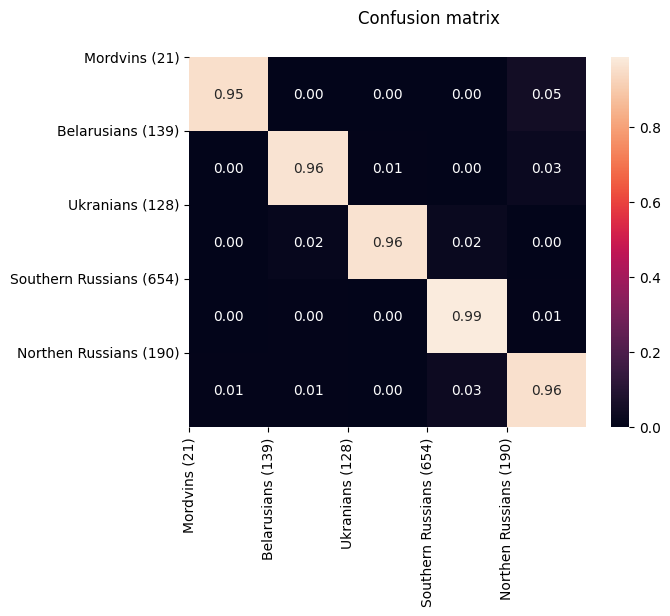

Current f1 score weighted: 0.9752873954984207
Current f1 score macro: 0.9648809116311323
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 26000
Time elapsed in min:  9.171315956115723
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.96      0.96      0.96       139
           2       0.98      0.96      0.97       128
           3       0.99      0.99      0.99       654
           4       0.95      0.96      0.95       190

    accuracy                           0.98      1132
   macro avg       0.97      0.96      0.96      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

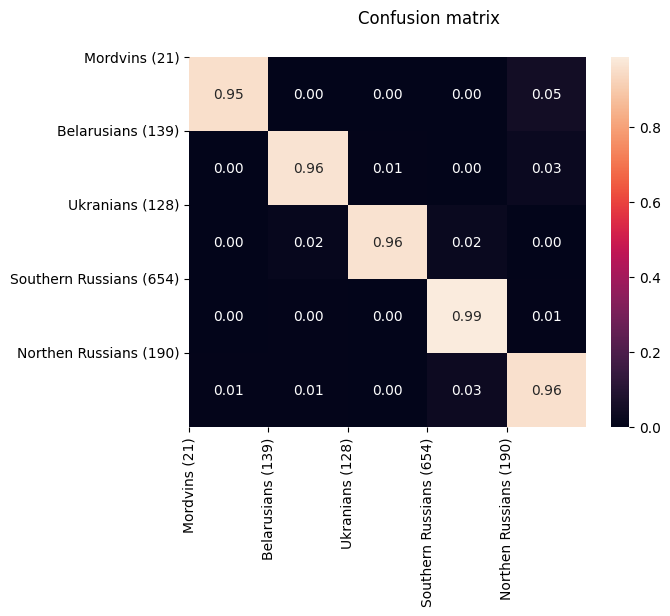

Current f1 score weighted: 0.9752873954984207
Current f1 score macro: 0.9648809116311323
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 27000
Time elapsed in min:  9.52154363791148
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.96      0.96      0.96       139
           2       0.98      0.96      0.97       128
           3       0.99      0.99      0.99       654
           4       0.95      0.96      0.96       190

    accuracy                           0.98      1132
   macro avg       0.97      0.96      0.96      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

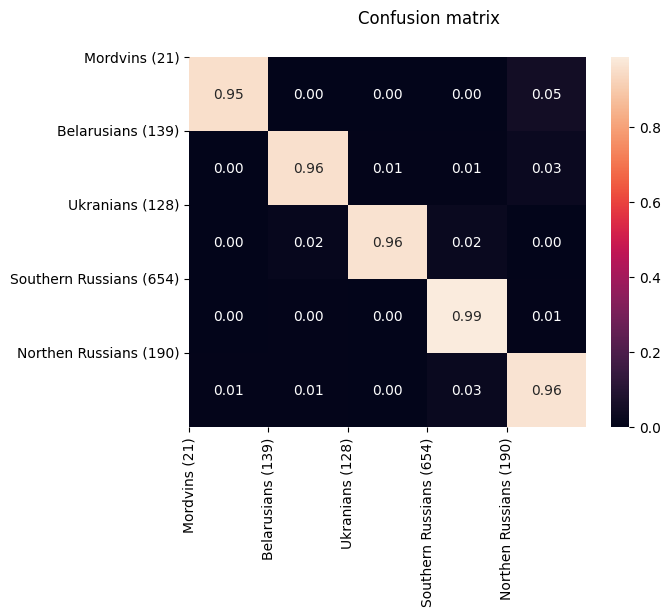

Current f1 score weighted: 0.9752871710761309
Current f1 score macro: 0.9646799219397841
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 28000
Time elapsed in min:  9.872424864768982
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.97      0.95      0.96       139
           2       0.98      0.98      0.98       128
           3       0.99      0.99      0.99       654
           4       0.95      0.98      0.97       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

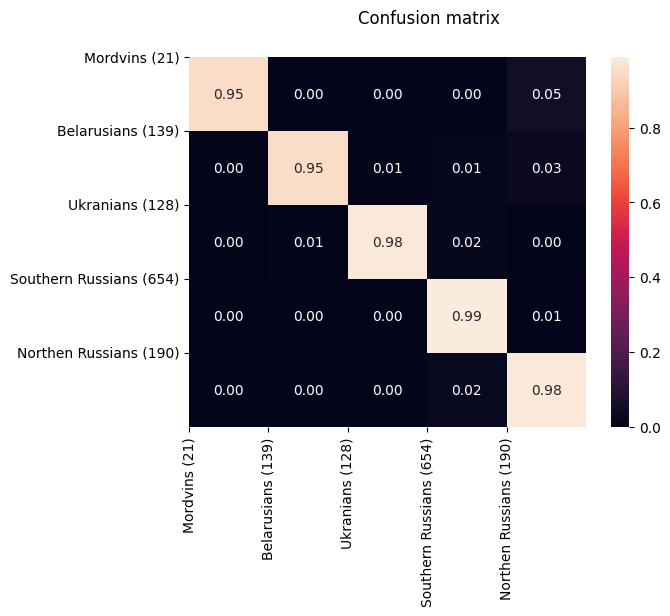

Current f1 score weighted: 0.9796841135520281
Current f1 score macro: 0.9740006526583864
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 29000
Time elapsed in min:  10.219462343056996
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.98      0.94      0.96       139
           2       0.98      0.98      0.98       128
           3       0.99      0.99      0.99       654
           4       0.94      0.98      0.96       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

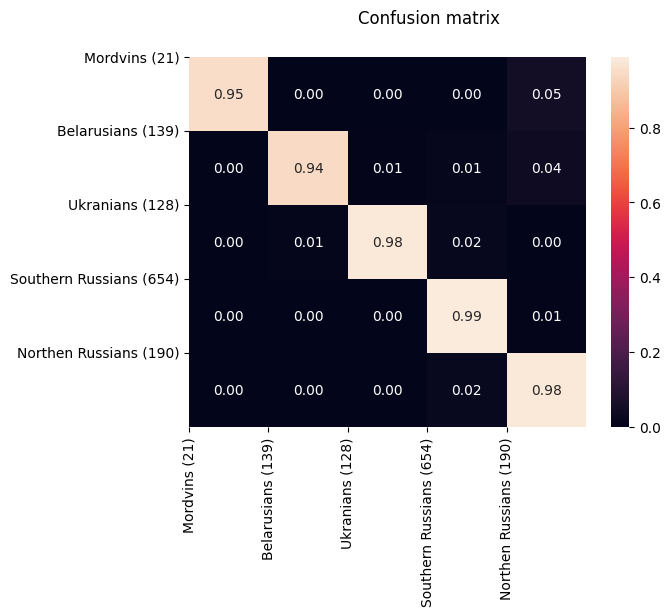

Current f1 score weighted: 0.9788100064226821
Current f1 score macro: 0.972943353368529
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 30000
Time elapsed in min:  10.568713128566742
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.98      0.94      0.96       139
           2       0.98      0.98      0.98       128
           3       0.99      0.99      0.99       654
           4       0.94      0.98      0.96       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

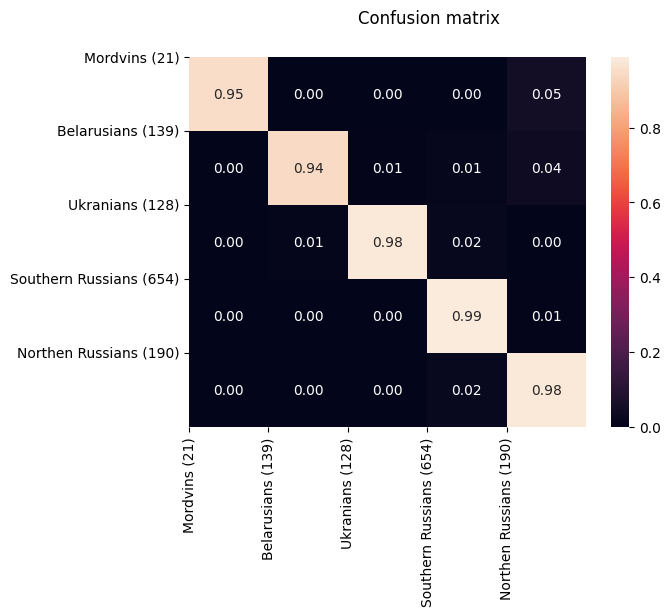

Current f1 score weighted: 0.9788100064226821
Current f1 score macro: 0.972943353368529
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 31000
Time elapsed in min:  10.914036126931508
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.98      0.94      0.96       139
           2       0.98      0.98      0.98       128
           3       0.99      0.99      0.99       654
           4       0.94      0.98      0.96       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

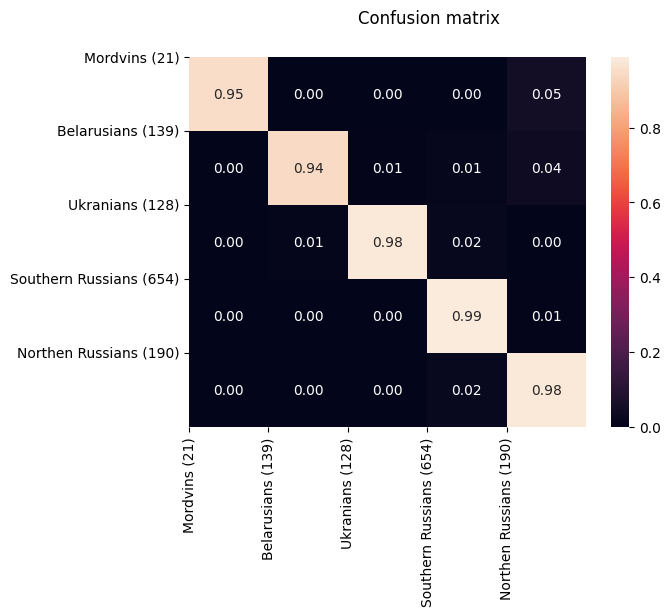

Current f1 score weighted: 0.9788100064226821
Current f1 score macro: 0.972943353368529
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 32000
Time elapsed in min:  11.264579319953919
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.98      0.94      0.96       139
           2       0.98      0.98      0.98       128
           3       0.99      0.99      0.99       654
           4       0.94      0.98      0.96       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

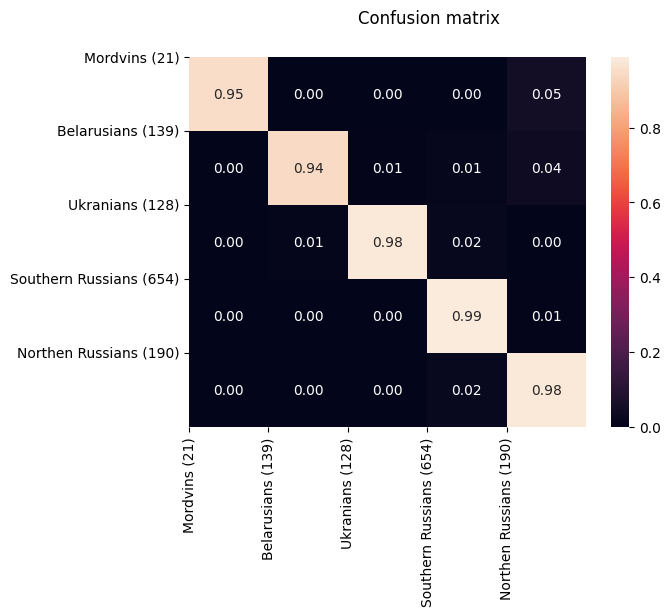

Current f1 score weighted: 0.9788100064226821
Current f1 score macro: 0.972943353368529
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 33000
Time elapsed in min:  11.612204349040985
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.98      0.94      0.96       139
           2       0.98      0.98      0.98       128
           3       0.99      0.99      0.99       654
           4       0.94      0.97      0.96       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

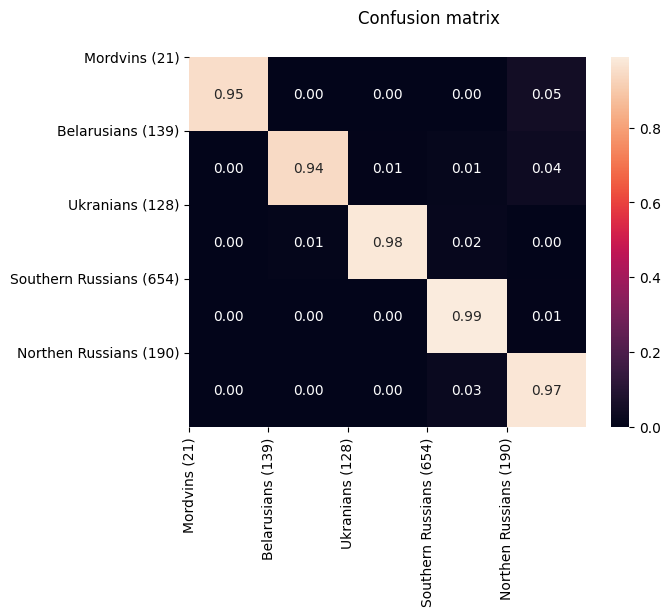

Current f1 score weighted: 0.9779223623620558
Current f1 score macro: 0.972254216495636
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309
Step 34000
Time elapsed in min:  11.964994859695434
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.98      0.94      0.96       139
           2       0.98      0.98      0.98       128
           3       0.99      0.99      0.99       654
           4       0.94      0.97      0.96       190

    accuracy                           0.98      1132
   macro avg       0.98      0.97      0.97      1132
weighted avg       0.98      0.98      0.98      1132



<Figure size 640x480 with 0 Axes>

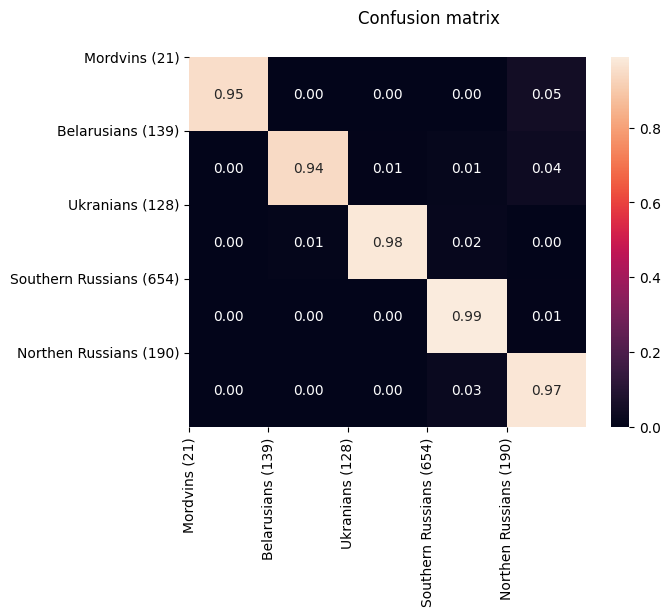

Current f1 score weighted: 0.9779223623620558
Current f1 score macro: 0.972254216495636
Max f1 score weighted: 0.9823646624609149
Max f1 score macro: 0.9762393059884309


In [9]:
train(data, 1000, 35000, test_graphs, mask_array)

# Little tutorial

Access test graphs

In [10]:
test_graphs[0]

Data(x=[2636, 5], edge_index=[2, 65844], y=[2636], weight=[65844], num_classes=5)

How many test graphs?

In [11]:
len(test_graphs)

1132

In [12]:
type(test_graphs)

list

Access features in graph

In [13]:
test_graphs[0].x

tensor([[164.7216,   0.0000,   0.0000,  52.3554,  27.0177],
        [  0.0000,  17.7281,  26.0041, 316.7786,  39.2319],
        [  0.0000,   9.4032,  31.3934,  49.3789,  18.9441],
        ...,
        [  0.0000,  55.5323,  27.7566, 108.4818,  36.5222],
        [  0.0000, 116.9001,  17.3628, 148.0721,  19.3620],
        [127.3277,   0.0000,   0.0000,  42.7549,  43.5810]], device='cuda:0',
       dtype=torch.float64)

In [14]:
test_graphs[0].edge_index

tensor([[   0,    0,    0,  ..., 2635, 2635, 2635],
        [  89,  162,  194,  ..., 2268, 2324, 2326]], device='cuda:0')

Same for train graph

In [15]:
data

Data(x=[2635, 5], edge_index=[2, 65810], y=[2635], weight=[65810], num_classes=5)

# Debug

Let's create dumb dataset

In [16]:
debugging_df = pd.DataFrame([['node_0', 'node_1', 'a', 'a', 10, 0],
                            ['node_0', 'node_2', 'a', 'b', 11, 0],
                            ['node_0', 'node_4', 'a', 'b', 10, 0],
                            ['node_1', 'node_2', 'a', 'b', 10, 0],
                            ['node_1', 'node_3', 'a', 'b', 10, 0],
                            ['node_0', 'node_3', 'a', 'b', 10, 0],
                            ['node_0', 'node_4', 'a', 'b', 10, 0],
                            ['node_0', 'node_5', 'a', 'a', 17, 0],
                            ['node_1', 'node_4', 'a', 'b', 10, 0],
                            ['node_1', 'node_5', 'a', 'a', 10, 0],
                            ['node_1', 'node_6', 'a', 'a', 10, 0],
                            ['node_1', 'node_7', 'a', 'a', 10, 0],
                            ['node_2', 'node_8', 'b', 'a', 15, 0],
                            ['node_2', 'node_3', 'b', 'b', 10, 0],
                            ['node_2', 'node_4', 'b', 'b', 10.5, 0],
                            ['node_2', 'node_10', 'b', 'b', 10, 0],
                            ['node_3', 'node_9', 'b', 'b', 10, 0],
                            ['node_3', 'node_6', 'b', 'a', 10, 0],
                            ['node_3', 'node_7', 'b', 'a', 10, 0]], columns=['node_id1', 'node_id2', 'label_id1', 'label_id2', 'ibd_sum', 'ibd_n'])

debugging_df

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,node_0,node_1,a,a,10.0,0
1,node_0,node_2,a,b,11.0,0
2,node_0,node_4,a,b,10.0,0
3,node_1,node_2,a,b,10.0,0
4,node_1,node_3,a,b,10.0,0
5,node_0,node_3,a,b,10.0,0
6,node_0,node_4,a,b,10.0,0
7,node_0,node_5,a,a,17.0,0
8,node_1,node_4,a,b,10.0,0
9,node_1,node_5,a,a,10.0,0


Let's preprocess it

In [17]:
d_tr, d_ts, d_nks, d_mask_array = get_train_test_nodes(debugging_df, 0.5, mask_coeff=0.0, NC=False) # to-do: 70:30 split ration because kenenbek did it this way
d_data, d_test_graphs, d_types = make_train_test_dataset(debugging_df, d_tr, d_ts, d_nks, d_mask_array)

Processed 0 / 19 lines for training dataset
Processed 0 / 6 nodes
Processed 1 / 6 nodes
Processed 2 / 6 nodes
Processed 3 / 6 nodes
Processed 4 / 6 nodes
Processed 5 / 6 nodes
WARNING COUNTER: 1


<ipython-input-5-b3146f6c942b>:32: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_new.iloc[:, 0] = df_new.iloc[:, 0].apply(lambda n: int(n.split('_')[1]))
<ipython-input-5-b3146f6c942b>:33: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_new.iloc[:, 1] = df_new.iloc[:, 1].apply(lambda t: types.index(t))
<ipython-input-5-b3146f6c942b>:101: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]]

WARNING COUNTER should always be 0. This is dumb example, so it can be whatever number. If it's not zero, it means that some test nodes don't have edges to nodes in train dataset.

In [18]:
d_tr

[4, 0, 2, 1, 7]

Let's see how this pipline is actually working

In [19]:
d_data

Data(x=[5, 2], edge_index=[2, 16], y=[5], weight=[16], num_classes=2)

In [20]:
d_data.x

tensor([[30.0000, 10.5000],
        [10.0000, 31.0000],
        [21.0000, 10.5000],
        [20.0000, 20.0000],
        [10.0000,  0.0000]], dtype=torch.float64)

In [21]:
d_data.y

tensor([1, 0, 1, 0, 0])

In [22]:
d_data.edge_index

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4],
        [1, 1, 2, 3, 0, 0, 2, 3, 0, 1, 3, 0, 1, 2, 4, 3]])

In [23]:
d_data.weight

tensor([10.0000, 10.0000, 10.5000, 10.0000, 10.0000, 10.0000, 11.0000, 10.0000,
        10.5000, 11.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000],
       dtype=torch.float64)

In [24]:
d_mask_array

[True, True, True, True, True]

In [25]:
d_test_graphs[1].edge_index

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 4, 5, 5],
        [1, 1, 2, 3, 0, 0, 2, 3, 5, 0, 1, 3, 0, 1, 2, 4, 5, 3, 1, 3]])

Example of how to preprocess graph with build-in methods of pytorch_geometric (very slow on large graphs). That is why I rewrote it using numba

In [26]:
G = nx.Graph()

G.add_nodes_from([
      (1, {'y': 0, 'x': [0.5, 0.8, 0.9]}),
      (2, {'y': 0, 'x': [0.2, 0.8, 0.9]}),
      (3, {'y': 1, 'x': [0.3, 0.8, 0.9]}),
      (4, {'y': 1, 'x': [0.1, 0.8, 0.9]}),
      (5, {'y': 1, 'x': [0.2, 0.8, 0.9]}),
])

# Add some edges
G.add_edges_from([
                  (1, 2), (1, 4), (1, 5),
                  (2, 3), (2, 4),
                  (3, 2), (3, 5),
                  (4, 1), (4, 2),
                  (5, 1), (5, 3)
])

# Convert the graph into PyTorch geometric
pyg_graph = from_networkx(G)

pyg_graph.num_classes = 2

print(pyg_graph.num_features)

print(pyg_graph)

print(pyg_graph.x)

print(pyg_graph.y)

print(pyg_graph.edge_index)

3
Data(x=[5, 3], edge_index=[2, 12], y=[5], num_classes=2)
tensor([[0.5000, 0.8000, 0.9000],
        [0.2000, 0.8000, 0.9000],
        [0.3000, 0.8000, 0.9000],
        [0.1000, 0.8000, 0.9000],
        [0.2000, 0.8000, 0.9000]])
tensor([0, 0, 1, 1, 1])
tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
        [1, 3, 4, 0, 2, 3, 1, 4, 0, 1, 0, 2]])


In [27]:
G = nx.DiGraph()


# G.add_nodes_from([
#       (1, {'y': 0, 'x': [0.5, 0.8, 0.9]}), # is it possible to get rid of dict as data?
#       (2, {'y': 0, 'x': [0.2, 0.8, 0.9]}),
#       (3, {'y': 1, 'x': [0.3, 0.8, 0.9]}),
#       (4, {'y': 1, 'x': [0.1, 0.8, 0.9]}),
#       (5, {'y': 1, 'x': [0.2, 0.8, 0.9]}),
#       (7, {'y': 0, 'x': [0.7, 0.1, 0.7]}),
#       (800, {'y': 0, 'x': [0.7, 0.1, 0.7]}),
#       (100, {'y': 0, 'x': [0.7, 0.1, 0.7]}),
# ])
n = [(i, {'y': 0, 'x': [0.5, 0.8, 0.9+i]}) for i in range(39, 9, -1)]


G.add_nodes_from(n)

# Add some edges
# G.add_weighted_edges_from([
#                   (1, 2, 91), (1, 2, 91), (1, 4, 92), (1, 5, 93),
#                   (2, 3, 94), (2, 4, 95),
#                   (3, 2, 96), (3, 5, 97),
#                   (4, 1, 98), (4, 2, 99),
#                   (5, 1, 100), (5, 3, 101), (5,2, 102), (7, 2, 103), (800, 100, 104), (100, 1, 105)
# ])
e = [(i, i+1, 100+i) for i in range(10, 40 - 1)] + [(i+1, i, 100+i) for i in range(10, 40 - 1)]

G.add_weighted_edges_from(e)

#G.add_weighted_edges_from

# Convert the graph into PyTorch geometric
pyg_graph_big = from_networkx(G)
pyg_graph_big.edge_index

tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18,
         18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27,
         27, 28, 28, 29],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18, 17,
         19, 18, 20, 19, 21, 20, 22, 21, 23, 22, 24, 23, 25, 24, 26, 25, 27, 26,
         28, 27, 29, 28]])

In [28]:
pyg_graph_big

Data(x=[30, 3], edge_index=[2, 58], y=[30], weight=[58])